In [1]:
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from biogeme.version import getText # なくても良い（バージョン確認のため導入）
from biogeme.biogeme import BIOGEME
from biogeme.database import Database
from biogeme.expressions import Beta, Variable, log, exp
from biogeme import models
from biogeme.models import loglogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# biogemeのバージョン確認
print(getText())

getText is deprecated; use get_text instead.


biogeme 3.3.1 [2025-12-16]
Home page: http://biogeme.epfl.ch
Submit questions to https://groups.google.com/d/forum/biogeme
Michel Bierlaire, Transport and Mobility Laboratory, Ecole Polytechnique Fédérale de Lausanne (EPFL)



In [3]:
# マスターデータの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/01master_data/Logit_master6.csv", encoding="utf-8-sig")

# 欠損している部分をすべて0で補完（必要な処理は作成時にやってるから大丈夫）
master_df = master_df.fillna(0)

# 男性のみ抽出
male_df = master_df[master_df["sex"] == 1]
female_df = master_df[master_df["sex"] == 2]

# 確認
print(len(male_df))
print(len(female_df))
male_df.columns

31152
16316


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation', 'NearestStation_code', 'near_area_syou',
       'near_area_kinrin', 'near_area_sum', 'near_area_syou500',
       'near_area_kinrin500', 'near_area_sum500', 'near_area_syou300',
       'near_area_kinrin300', 'near_area_sum300', 'near_o_area_syou',
       'near_o_area_kinrin', 'near_o_area_sum', 'near_o_area_syou500',
       'near_o_area_kinrin500', 'near_o_area_sum500', 'near_o_area_syou300',
       'near_o_area_kinrin300', 'near_o_area_sum300', 'WorkplaceStation',
       'WorkplaceStation_code', 'WP_area_syou', 'WP_area_kinrin',
       'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500', 'WP_area_sum500',
       'WP_area_syou300', 'WP_area_kinrin300', 'WP_area_sum300',
       'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_are

In [4]:
# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
male_df = male_df.drop(columns=drop_cols)
female_df = female_df.drop(columns=drop_cols)
male_df.columns

Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'WorkTime[m]', 'first_transportation',
       'NearestStation_code', 'near_area_syou', 'near_area_kinrin',
       'near_area_sum', 'near_area_syou500', 'near_area_kinrin500',
       'near_area_sum500', 'near_area_syou300', 'near_area_kinrin300',
       'near_area_sum300', 'near_o_area_syou', 'near_o_area_kinrin',
       'near_o_area_sum', 'near_o_area_syou500', 'near_o_area_kinrin500',
       'near_o_area_sum500', 'near_o_area_syou300', 'near_o_area_kinrin300',
       'near_o_area_sum300', 'WorkplaceStation_code', 'WP_area_syou',
       'WP_area_kinrin', 'WP_area_sum', 'WP_area_syou500', 'WP_area_kinrin500',
       'WP_area_sum500', 'WP_area_syou300', 'WP_area_kinrin300',
       'WP_area_sum300', 'WP_o_area_syou', 'WP_o_area_kinrin', 'WP_o_area_sum',
       'WP_o_area_syou500', 'WP_o_area_kinrin500', 'WP_o_area

In [5]:
male_df[['MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdMembers(all)', 'WorkTime[m]', 'near_area_syou300']].describe()

,MainlineTime[m],AccessTime_used[m],HouseholdMembers(all),WorkTime[m],near_area_syou300
count,31152.000000,31152.000000,31152.000000,31152.000000,3.115200e+04
mean,58.849570,10.817097,2.777189,618.413906,4.365153e+05
std,24.425784,5.947451,1.209447,103.403882,4.499434e+05
min,6.642953,1.184588,1.000000,248.000000,0.000000e+00
25%,41.327474,6.267356,2.000000,560.000000,0.000000e+00
50%,55.404063,9.666703,3.000000,600.000000,3.216042e+05
75%,74.669209,14.159591,4.000000,680.000000,6.842000e+05
max,141.901349,37.509687,9.000000,900.000000,2.981425e+06


In [6]:
# biogeme.databaseに格納
m_master_db = Database("PTdata", male_df)

In [7]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou300")       # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = m_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = m_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = m_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = m_master_db.define_variable("AT_c",    AT_min - np.mean(male_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = m_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = m_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = m_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = m_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = m_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = m_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = m_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = m_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [8]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_m = BIOGEME(m_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_m.model_name = "binlogit_mode_dummy_male"
bio_m.calculate_null_loglikelihood(avail={0:1, 1:1})
res_male = bio_m.estimate()
print(res_male.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_male = get_pandas_estimated_parameters(estimation_results=res_male)
print(pandas_results_male)

Results for model binlogit_mode_dummy_male
Nbr of parameters:		12
Sample size:			31152
Excluded data:			0
Null log likelihood:		-21592.92
Final log likelihood:		-10682.35
Likelihood ratio test (null):		21821.14
Rho square (null):			0.505
Rho bar square (null):			0.505
Akaike Information Criterion:	21388.7
Bayesian Information Criterion:	21488.86

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.026366         0.124075       32.451034        0.000000
1      B_MACMTIME -0.481414         0.046255      -10.407817        0.000000
2      B_WORKTIME -0.491937         0.011055      -44.498537        0.000000
3       B_HHM_all -0.203477         0.016400      -12.406822        0.000000
4   B_N_EKI_SCORE  0.098587         0.040061        2.460895        0.013859
5     B_D_BICYCLE -0.011542         0.138722       -0.083202        0.933691
6         B_D_BUS  0.065522         0.212694        0.308057        0.758039
7         B_D_CAR -0.332282        

In [9]:
# biogeme.databaseに格納
f_master_db = Database("PTdata", female_df)

In [10]:
# 変数（main の DB）
PRITRIP   = Variable("PriTrip")                 # 目的変数（0/1）
MACM_min  = Variable("MainlineTime[m]")         # 本線（分）
WORK_min  = Variable("WorkTime[m]")             # 就業（分）
HHM       = Variable("HouseholdMembers(all)")   # 世帯人数
LU        = Variable("near_area_syou300")       # 駅土地利用指標
AT_min    = Variable("AccessTime_used[m]")      # その日の実際の端末時間（分）
MODE      = Variable("first_transportation")    # 1:歩, 2:自転車, 4:バス, 5:車

# スケーリング
MACM_h = f_master_db.define_variable("MACM_h",  MACM_min / 60)   # /時
WORK_h = f_master_db.define_variable("WORK_h",  WORK_min / 60)   # /時
LU_s   = f_master_db.define_variable("LU_s",    LU / 1000000) # 1,000,000㎡あたり
AT_c   = f_master_db.define_variable("AT_c",    AT_min - np.mean(female_df["AccessTime_used[m]"])) 

# 各モード利用可否
WALK_AV    = Variable("walk_av")
BICYCLE_AV = Variable("bicycle_av")
BUS_AV     = Variable("bus_av")
CAR_AV     = Variable("car_av")

# モード・ダミー（歩=基準なので作らない）
D_BIC = f_master_db.define_variable("D_BIC", (MODE == 2))
D_BUS = f_master_db.define_variable("D_BUS", (MODE == 4))
D_CAR = f_master_db.define_variable("D_CAR", (MODE == 5))
D_WAL = f_master_db.define_variable("D_WAL", (MODE == 1)) # 交差項用に使う

# 交差項：端末時間 × モード（4本）
#AT_WAL = master_db.define_variable("AT_WAL", AT_c * D_WAL)
#AT_BIC = master_db.define_variable("AT_BIC", AT_c * D_BIC)
#AT_BUS = master_db.define_variable("AT_BUS", AT_c * D_BUS)
#AT_CAR = master_db.define_variable("AT_CAR", AT_c * D_CAR)

AT_WAL = f_master_db.define_variable("AT_WAL", AT_min * D_WAL)
AT_BIC = f_master_db.define_variable("AT_BIC", AT_min * D_BIC)
AT_BUS = f_master_db.define_variable("AT_BUS", AT_min * D_BUS)
AT_CAR = f_master_db.define_variable("AT_CAR", AT_min * D_CAR)

# 係数
ASC_YES  = Beta("ASC_YES", 0.0, None, None, 0)
B_MACM   = Beta("B_MACMTIME", -0.01, None, None, 0)  # /時
B_WORK   = Beta("B_WORKTIME", -0.30, None, None, 0)  # /時
B_HH     = Beta("B_HHM_all",  0.0, None, None, 0)
B_LU     = Beta("B_N_EKI_SCORE", 0.0, None, None, 0) # 駅土地利用を入れるなら

# モード・ダミー（歩が基準）→ 定数のずれ
B_D_BIC  = Beta("B_D_BICYCLE", 0.0, None, None, 0)
B_D_BUS  = Beta("B_D_BUS",     0.0, None, None, 0)
B_D_CAR  = Beta("B_D_CAR",     0.0, None, None, 0)

# 端末時間のモード別傾き（/分）
B_AT_WAL = Beta("B_AT_WALK",    -0.01, None, None, 0)
B_AT_BIC = Beta("B_AT_BICYCLE", -0.01, None, None, 0)
B_AT_BUS = Beta("B_AT_BUS",     -0.01, None, None, 0)
B_AT_CAR = Beta("B_AT_CAR",     -0.01, None, None, 0)

In [11]:
# 効用（V_NO=0 を基準に）
V_YES = (ASC_YES
         + B_MACM * MACM_h
         + B_WORK * WORK_h
         + B_HH   * HHM
         + B_LU * LU_s   # 利用駅土地利用指標
         + B_D_BIC * D_BIC + B_D_BUS * D_BUS + B_D_CAR * D_CAR
         + B_AT_WAL * AT_WAL + B_AT_BIC * AT_BIC + B_AT_BUS * AT_BUS + B_AT_CAR * AT_CAR)

V = {0: 0, 1: V_YES}

# モデルの推定と結果の表示
# 尤度関数の設定
logprob = loglogit(V, None, PRITRIP)

bio_f = BIOGEME(f_master_db, logprob, 
              generate_html=False, generate_yaml=False) # 推定結果保存可否
bio_f.model_name = "binlogit_mode_dummies_female"
bio_f.calculate_null_loglikelihood(avail={0:1, 1:1})
res_female = bio_f.estimate()
print(res_female.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results_female = get_pandas_estimated_parameters(estimation_results=res_female)
print(pandas_results_female)

Results for model binlogit_mode_dummies_female
Nbr of parameters:		12
Sample size:			16316
Excluded data:			0
Null log likelihood:		-11309.39
Final log likelihood:		-8342.662
Likelihood ratio test (null):		5933.455
Rho square (null):			0.262
Rho bar square (null):			0.261
Akaike Information Criterion:	16709.32
Bayesian Information Criterion:	16801.72

             Name     Value  Robust std err.  Robust t-stat.  Robust p-value
0         ASC_YES  4.263731         0.151011       28.234625        0.000000
1      B_MACMTIME -0.456340         0.054520       -8.370060        0.000000
2      B_WORKTIME -0.455826         0.013547      -33.646631        0.000000
3       B_HHM_all -0.231363         0.017670      -13.093192        0.000000
4   B_N_EKI_SCORE  0.091020         0.042223        2.155681        0.031109
5     B_D_BICYCLE -0.184285         0.160621       -1.147328        0.251246
6         B_D_BUS -0.044563         0.262392       -0.169836        0.865139
7         B_D_CAR -0.223434   

# 推定結果の可視化（感度分析）

In [12]:
# 固定値の算出
master_df[["WorkTime[m]", "MainlineTime[m]", "AccessTime_used[m]"]].describe()

,WorkTime[m],MainlineTime[m],AccessTime_used[m]
count,47468.000000,47468.000000,47468.000000
mean,604.826367,55.917761,10.387202
std,102.672286,24.009200,5.843204
min,248.000000,6.642953,1.184588
25%,550.000000,38.370306,5.968356
50%,600.000000,52.999831,9.208647
75%,660.000000,71.137090,13.610342
max,900.000000,142.063611,37.509687


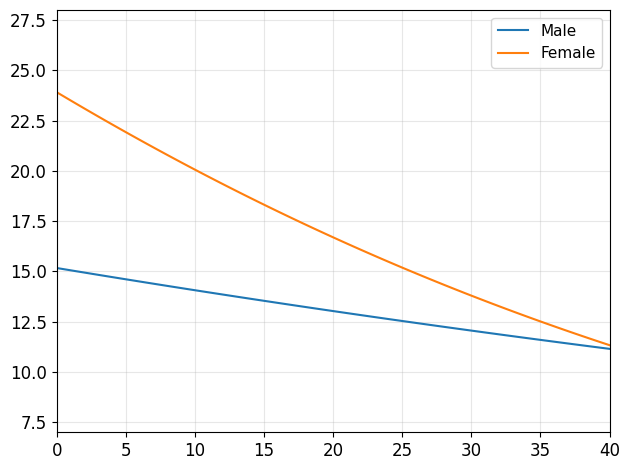

In [13]:
# 男女モデルによる端末時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_m = res_male.get_beta_values()
beta_f = res_female.get_beta_values()

# 端末時間の変動範囲
AT = np.arange(0, 40.0 + 0.5, 0.5)

def P_walk(beta, AT_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * work_time
        + beta["B_HHM_all"] * HHM
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AT_array
    )
    return logistic(V)

P_male = P_walk(beta_m, AT)
P_female = P_walk(beta_f, AT)

# 描画
plt.figure()
plt.plot(AT, P_male*100, label="Male")
plt.plot(AT, P_female*100, label="Female")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlabel("AT(min)[mode=walk]")
#plt.ylabel("Private-trip probability[%]")
plt.xlim(0, 40)
plt.ylim(7, 28)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [14]:
# 具体的な数値を算出
P_male_5 = P_walk(beta_m, 5)
P_male_15 = P_walk(beta_m, 15)
P_female_5 = P_walk(beta_f, 5)
P_female_15 = P_walk(beta_f, 15)
print("男性の端末時間の差", (P_male_5 - P_male_15)*100)
print("女性の端末時間の差", (P_female_5 - P_female_15)*100)

男性の端末時間の差 1.070383650413964
女性の端末時間の差 3.6072494991531032


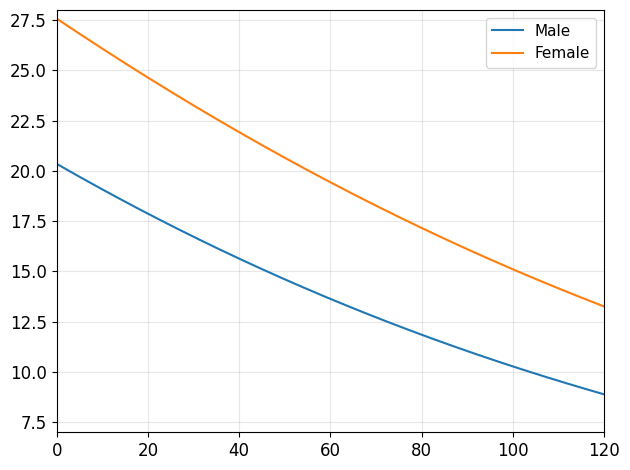

In [15]:
# 男女モデルによるメイン時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_m = res_male.get_beta_values()
beta_f = res_female.get_beta_values()

# 端末時間の変動範囲
MACM = np.arange(0, 120 + 0.5, 0.5)

def P_MACM(beta, MACM_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * work_time
        + beta["B_HHM_all"] * HHM
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * (MACM_array/60)
        + beta["B_AT_WALK"] * AccessTime
    )
    return logistic(V)

P_male = P_MACM(beta_m, MACM)
P_female = P_MACM(beta_f, MACM)

# 描画
plt.figure()
plt.plot(MACM, P_male*100, label="Male")
plt.plot(MACM, P_female*100, label="Female")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlabel("MACM(min)[mode=walk]")
#plt.ylabel("Private-trip probability[%]")
plt.xlim(0, 120)
plt.ylim(7, 28)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

In [16]:
# 具体的な数値を算出
P_male_20 = P_MACM(beta_m, 20)
P_male_40 = P_MACM(beta_m, 40)
P_female_20 = P_MACM(beta_f, 20)
P_female_40 = P_MACM(beta_f, 40)
print("男性の端末時間の差", (P_male_20 - P_male_40)*100)
print("女性の端末時間の差", (P_female_20 - P_female_40)*100)

男性の端末時間の差 2.2351269085232994
女性の端末時間の差 2.7144676700070702


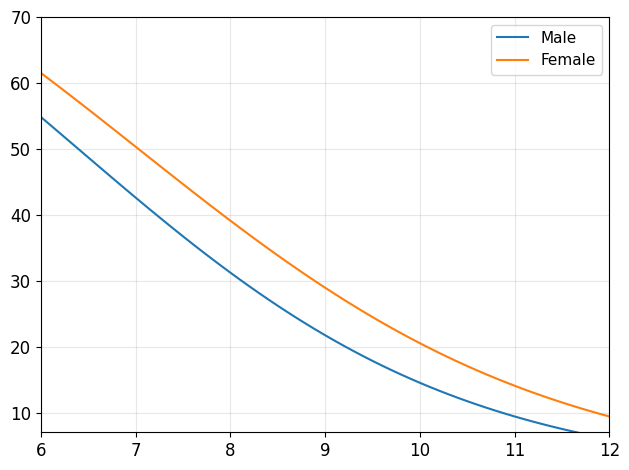

In [17]:
# 男女モデルによる就業時間の感度分析
# 固定値
work_time = master_df["WorkTime[m]"].mean() / 60          # 604分  hours
MACM_h    = master_df["MainlineTime[m]"].mean() / 60      # 56.1分 hours
AccessTime = master_df["AccessTime_used[m]"].mean()       # 10.5分
HHM = 2
lu  = 677535.273703768 / 1e6

# ロジスティクス関数の定義
def logistic(x):
    return 1.0 / (1.0 + np.exp(-x))

# パラメータ値の取得
beta_m = res_male.get_beta_values()
beta_f = res_female.get_beta_values()

# 端末時間の変動範囲
WT = np.arange(6, 12 + 0.1, 0.1)

def P_Work(beta, WT_array):
    V = (
        beta["ASC_YES"] 
        + beta["B_WORKTIME"] * WT_array
        + beta["B_HHM_all"] * HHM
        + beta["B_N_EKI_SCORE"] * lu
        + beta["B_MACMTIME"] * MACM_h
        + beta["B_AT_WALK"] * AccessTime
    )
    return logistic(V)

P_male = P_Work(beta_m, WT)
P_female = P_Work(beta_f, WT)

# 描画
plt.figure()
plt.plot(WT, P_male*100, label="Male")
plt.plot(WT, P_female*100, label="Female")

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.xlabel("WT(h)")
#plt.ylabel("Private-trip probability[%]")
plt.xlim(6, 12)
plt.ylim(7, 70)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()